In [1]:
import cv2
import os


IMAGE_PATH = "../images/"
image_map = {}

for file in os.listdir(IMAGE_PATH):
    image_f = os.path.join(IMAGE_PATH, file)
    img = cv2.imread(image_f)
    image_map[file.replace(".jpg", "")] = img

In [2]:
for file, item in list(image_map.items())[:10]:
    cv2.imshow(file, item)
    cv2.waitKey(1)
    cv2.destroyAllWindows()

In [3]:
import numpy as np
width_l = np.zeros(len(image_map))
height_l = np.zeros(len(image_map))
for num, item in enumerate(image_map.values()):
    width, height, _ = item.shape
    width_l[num] = width
    height_l[num] = height

In [4]:
import pandas as pd

names = pd.DataFrame({"Name" : list(image_map.keys())})
names["Name"] = names["Name"]
df = pd.DataFrame({"Height" : height_l, "Width" : width_l}, index = names["Name"])

In [5]:
df.head()

,Height,Width
Name,,
abomasnow,360.0,361.0
abra,360.0,253.0
absol,268.0,400.0
accelgor,360.0,325.0
aegislash-shield,333.0,400.0


In [6]:
df.describe()

,Height,Width
count,893.000000,893.000000
mean,337.697648,345.001120
std,40.097839,62.287153
min,120.000000,120.000000
25%,330.000000,306.000000
50%,360.000000,363.000000
75%,360.000000,400.000000
max,360.000000,400.000000


In [7]:
master_df = pd.read_csv("./pokemon.csv")
master_df["Name"] = master_df["Name"].str.lower()

In [8]:
def transform(img, width = 256, height = 256):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    res = cv2.resize(img, (width, height), interpolation = cv2.INTER_CUBIC)
    
    return res



In [9]:
for file, item in list(image_map.items())[:10]:
    #cv2.imshow(file, item)
    
    res = transform(item)
    #cv2.imshow(file + "_transformed", cv2.cvtColor(res, cv2.COLOR_HSV2BGR))
    
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

In [10]:
type_df = df.reset_index().merge(master_df, left_on = "Name", right_on = "Name")

keys = type_df["Name"]
types1 = type_df["Type1"]
types2 = type_df["Type2"]

In [11]:
try:
    os.mkdir("./pokemon_imgs")
except:
    print("Could not create folder pokemon_imgs. Folder already exists.")
    
for _type in np.unique(types1):
    try:
        os.mkdir(os.path.join("./pokemon_imgs", _type))
    except:
        print(f"Could not create subfolder /{_type}")

transformed_map = {}

for file, item in list(image_map.items()):
    
    res = transform(item)
    
    transformed_map[file] = res
    
for key, _type in zip(keys, types1):
    path = os.path.join("./pokemon_imgs", _type, key + ".jpg")
    cv2.imwrite(path, transformed_map[key])
    

Could not create folder pokemon_imgs. Folder already exists.
Could not create subfolder /Bug
Could not create subfolder /Dark
Could not create subfolder /Dragon
Could not create subfolder /Electric
Could not create subfolder /Fairy
Could not create subfolder /Fighting
Could not create subfolder /Fire
Could not create subfolder /Flying
Could not create subfolder /Ghost
Could not create subfolder /Grass
Could not create subfolder /Ground
Could not create subfolder /Ice
Could not create subfolder /Normal
Could not create subfolder /Poison
Could not create subfolder /Psychic
Could not create subfolder /Rock
Could not create subfolder /Steel
Could not create subfolder /Water


In [12]:
types = [[i[0], i[1]] if i[1] != "None" else [i[0]] for i in zip(types1, types2) ]

In [13]:
image_dataset = pd.DataFrame({"Id" : keys, "Type" : types})

In [14]:
image_dataset.head()

,Id,Type
0,abomasnow,"[Grass, Ice]"
1,abra,[Psychic]
2,absol,[Dark]
3,accelgor,[Bug]
4,aerodactyl,"[Rock, Flying]"


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer 

mlb = MultiLabelBinarizer ()
res = pd.DataFrame(mlb.fit_transform(image_dataset["Type"]),
                   columns=mlb.classes_,
                   index=image_dataset.index)

In [16]:
final_dataset = image_dataset.join(res)

In [17]:
train, test = train_test_split(final_dataset, random_state = 42)
train = train.reset_index(drop = True)
test = test.reset_index(drop = True)

In [18]:
train.to_csv("./types_train.csv", index = False)
test.to_csv("./types_test.csv", index = False)

In [148]:
from tensorflow import keras

from tensorflow.keras import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import SGD


In [20]:
train.columns

Index(['Id', 'Type', 'Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting',
       'Fire', 'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison',
       'Psychic', 'Rock', 'Steel', 'Water'],
      dtype='object')

In [21]:
train_image = []
for i in tqdm(range(train.shape[0])):
    img = image.load_img('../images/' + train['Id'][i]+'.jpg', target_size=(256,256,3))
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

100%|███████████████████████████████████████████████████████████████████████████████| 639/639 [00:02<00:00, 268.53it/s]


In [22]:
X.shape

(639, 256, 256, 3)

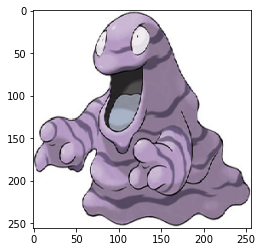

In [23]:
plt.imshow(X[2])

In [27]:
y = np.array(train.drop(['Id', 'Type'],axis=1))
y.shape

(639, 18)

In [206]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [213]:
train_size = len(X_train)
val_size = len(X_test)
n_classes = y_test.shape[1]
batch_size = 16


base_model = keras.applications.xception.Xception(weights="imagenet",
include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="sigmoid")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False
    
    
    
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
metrics=["accuracy"])
history = model.fit(X_train, y_train,
validation_data=(X_test, y_test),
epochs=5, batch_size = batch_size)

Train on 543 samples, validate on 96 samples
Epoch 1/5
543/543 [==============================] - 14s 26ms/sample - loss: 0.3740 - accuracy: 0.8979 - val_loss: 0.3888 - val_accuracy: 0.9144
Epoch 2/5
543/543 [==============================] - 9s 16ms/sample - loss: 0.3011 - accuracy: 0.9157 - val_loss: 0.3428 - val_accuracy: 0.9149
Epoch 3/5
543/543 [==============================] - 9s 16ms/sample - loss: 0.2790 - accuracy: 0.9158 - val_loss: 0.3373 - val_accuracy: 0.9155
Epoch 4/5
543/543 [==============================] - 9s 17ms/sample - loss: 0.2700 - accuracy: 0.9162 - val_loss: 0.3384 - val_accuracy: 0.9144
Epoch 5/5
543/543 [==============================] - 9s 17ms/sample - loss: 0.2585 - accuracy: 0.9161 - val_loss: 0.3407 - val_accuracy: 0.9126


In [214]:
for layer in base_model.layers:
    layer.trainable = True
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.001)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
metrics=["accuracy"])
history = model.fit(X_train, y_train,
validation_data=(X_test, y_test),
epochs=5,  batch_size = batch_size)

Train on 543 samples, validate on 96 samples
Epoch 1/5
 16/543 [..............................] - ETA: 9:17

ResourceExhaustedError:  OOM when allocating tensor with shape[16,128,125,125] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_15/block2_sepconv2/separable_conv2d/depthwise (defined at <ipython-input-214-bc887b443b3f>:8) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_415799]

Function call stack:
distributed_function


In [212]:
import random 

%matplotlib 
#plt.figure(figsize = (5, 5))

for j, _id in enumerate(random.sample(range(len(test)), len(test))):
    

 
    
    img = image.load_img('../images/' + test['Id'][_id]+'.jpg',target_size=(256,256,3))
    img = image.img_to_array(img)
    img = img/255

    classes = np.array(train.columns[2:])
    proba = model.predict(img.reshape(1,256,256,3))
    top_3 = np.argsort(proba[0])[:-6:-1]
    
    if(proba.max() > 0.5):
        print("############################")
        print(test['Id'][_id])
        print("############################")
        print("############################")
        for i in range(5):
            print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
        print("############################")
        #plt.subplot(5, 5, j%25+1)
        #plt.axis('off')
        #plt.imshow(img)

Using matplotlib backend: Qt5Agg
############################
mantyke
############################
############################
Water (0.538)
Psychic (0.0664)
Normal (0.0517)
Grass (0.0332)
Flying (0.0325)
############################


In [131]:
len(test)

213